In [1]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import numba
import correctionlib
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
@numba.jit
def get_matching_pairs_indices(idx_quark, idx_jets, builder, builder2):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        builder2.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done:
                if j not in j_done:
                    builder.append(i)
                    q_done.append(q)
                    j_done.append(j)
                else: 
                    builder2.append(i)
        builder.end_list()
        builder2.end_list()
    return builder, builder2

def metric_pt(obj, obj2):
    return abs(obj.pt - obj2.pt)

def object_matching(obj, obj2, dr_min, pt_min=None):
    # Compute deltaR(quark, jet) and save the nearest jet (deltaR matching)
    deltaR  = ak.flatten(obj.metric_table(obj2), axis=2)
    deltaPt = ak.flatten(obj.metric_table(obj2, metric=metric_pt), axis=2)
    # keeping only the pairs with a deltaR min
    maskDR = deltaR < dr_min
    if pt_min is not None:
        maskPt = deltaPt < pt_min
        maskDR = maskDR & maskPt
    deltaRcut = deltaR[maskDR]
    idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
    pairs = ak.argcartesian([obj, obj2])[maskDR]
    pairs_sorted = pairs[idx_pairs_sorted]
    idx_obj, idx_obj2 = ak.unzip(pairs_sorted)
    
    _idx_matched_pairs, _idx_missed_pairs = get_matching_pairs_indices(idx_obj, idx_obj2, ak.ArrayBuilder(), ak.ArrayBuilder())
    idx_matched_pairs = _idx_matched_pairs.snapshot()
    idx_missed_pairs = _idx_missed_pairs.snapshot()
    # The invalid jet matches result in a None value. Only non-None values are selected.
    matched_obj  = obj[idx_obj[idx_matched_pairs]]
    matched_obj2 = obj2[idx_obj2[idx_matched_pairs]]
    deltaR_matched = deltaRcut[idx_matched_pairs]

    return matched_obj, matched_obj2, deltaR_matched

In order to apply the JER smearing, we have to match the jets to the corresponding gen-level jets.
To do that, we require $\Delta$R to be less than half the jet cone radius. In addition we require that the absolute difference between the jet and gen-level jet $p_T$ is less than $3\sigma_{JER}p_T$, where $\sigma_{JER}$ is the jet $p_T$ resolution as read from the JER correction file.

In [3]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100).events()

Here, as an example, we apply a cut on $p_T$ at 15 GeV to check that the implementation of the cut using `metric_table()` does what we expect.

In [4]:
pt_min = 15
matched_genjets, matched_jets, deltaR_matched = object_matching(events.GenJet, events.Jet, 0.2)
matched_genjets_pt, matched_jets_pt, deltaR_matched_pt = object_matching(events.GenJet, events.Jet, 0.2, pt_min=pt_min)
matched_jets.pt

<Array [[75.2, 178, 19.5, ... 109, 24.4, 19.6]] type='100 * var * float32[parame...'>

In [5]:
matched_genjets.pt

<Array [[70.8, 187, 13.8, ... 19.5, 12.5]] type='100 * var * float32[parameters=...'>

In [6]:
deltaPt    = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt_pt = ak.flatten(matched_jets_pt.pt - matched_genjets_pt.pt)
deltaPt

<Array [4.34, -8.74, 5.64, ... 4.94, 7.08] type='866 * float32'>

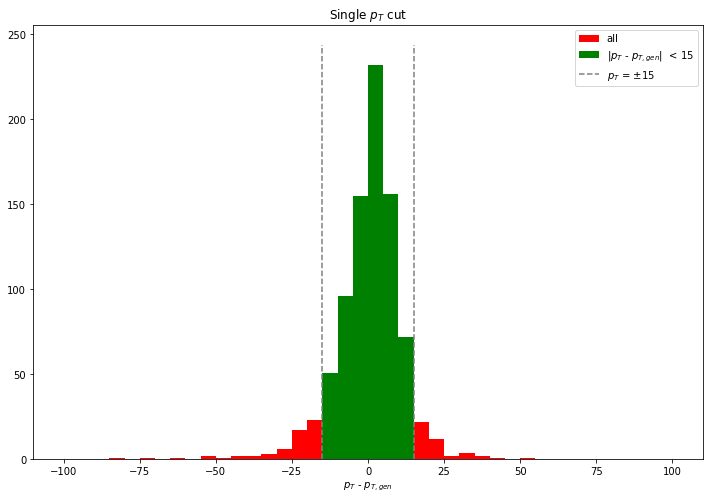

In [7]:
plt.figure(figsize=[12,8])
n, bins, patches = plt.hist(deltaPt, bins=np.linspace(-100, 100, 41), color='red', label="all");
plt.hist(deltaPt_pt, bins=np.linspace(-100, 100, 41), color='green', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min}");
plt.xlabel("$p_T$ - $p_{T,gen}$");
plt.vlines([-pt_min, pt_min], 0, 1.05*max(n), linestyle='dashed', color='grey', label=f"$p_T$ = $\pm${pt_min}")
plt.title("Single $p_T$ cut")
plt.legend();
#plt.hist(deltaPt);

When we want to take into account the JER and smear the jet $p_T$, the cut on the absolute $p_T$ difference is not a single number but an array since the jet $p_T$ resolution depends in general on ($p_T$, $\eta$, $\rho$) of the jet.

In [8]:
ones = ak.ones_like(events.event)
pt_min = ak.concatenate((10*ones[:33], 15*ones[33:66], 20*ones[66:]))
matched_genjets, matched_jets, deltaR_matched = object_matching(events.GenJet, events.Jet, 0.2)
matched_genjets_pt, matched_jets_pt, deltaR_matched_pt = object_matching(events.GenJet, events.Jet, 0.2, pt_min=pt_min)
matched_jets.pt

<Array [[75.2, 178, 19.5, ... 109, 24.4, 19.6]] type='100 * var * float32[parame...'>

In [9]:
deltaPt    = ak.flatten(matched_jets.pt - matched_genjets.pt)
deltaPt_pt = ak.flatten(matched_jets_pt.pt - matched_genjets_pt.pt)
deltaPt

<Array [4.34, -8.74, 5.64, ... 4.94, 7.08] type='866 * float32'>

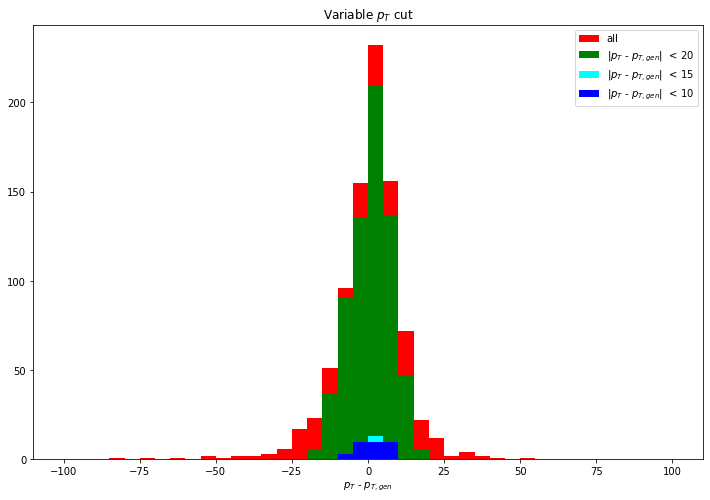

In [10]:
plt.figure(figsize=[12,8])
n, bins, patches = plt.hist(deltaPt, bins=np.linspace(-100, 100, 41), color='red', label="all");
plt.hist(deltaPt_pt[66:], bins=np.linspace(-100, 100, 41), color='green', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[66]}");
plt.hist(deltaPt_pt[33:66], bins=np.linspace(-100, 100, 41), color='cyan', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[33]}");
plt.hist(deltaPt_pt[:33], bins=np.linspace(-100, 100, 41), color='blue', label="|$p_T$ - $p_{T,gen}$| "+f" < {pt_min[0]}");
plt.xlabel("$p_T$ - $p_{T,gen}$");
plt.title("Variable $p_T$ cut")
plt.legend();
#plt.hist(deltaPt);

In [13]:
jsonfile = "/work/mmarcheg/POG/JME/2018UL/jet_jerc.json"
JERversion = "Summer19UL18_JRV2_MC"
typeJet = "AK4PFchs"
JECfile = correctionlib.CorrectionSet.from_file(jsonfile)
sf  = JECfile[f'{JERversion}_ScaleFactor_{typeJet}']
res = JECfile[f'{JERversion}_PtResolution_{typeJet}']

In [22]:
eta = ak.Array([1, 2, 0.4])
sf.evaluate(eta.to_numpy(), 'nom')

array([1.1481, 1.1423, 1.1436])